# Diffusion maps demo

In [34]:
%load_ext nb_mypy
%nb_mypy Off
%matplotlib ipympl

The nb_mypy extension is already loaded. To reload it, use:
  %reload_ext nb_mypy


In [35]:
import matplotlib.pyplot as plt
import nlsa.dynamics as dyn
import nlsa.function_algebra as fun
import nlsa.rkhs as rkhs
import nlsa.matrix_algebra as mat
import nlsa.vector_algebra as vec
import nlsa.vector_algebra_pairwise as vep
import numpy as np
from ipywidgets import interact, IntSlider
from functools import partial
from more_itertools import take
from nlsa.abstract_algebra import make_l2_innerp, riesz_dual, synthesis_operator
from nptyping import NDArray, Shape, Double

In [36]:
V = NDArray[Shape['N'], Double]

## Training data

We generate training data in $\mathbb R^2$ from an ergodic rotation on the circle.

In [67]:
a = 1 / np.sqrt(7) # shift angle per timestep
theta0 = 0.0 # Initial condition
n = 50 # Number of training samples

thetas = np.array(take(n, dyn.orbit(theta0, 
                                    dyn.circle_rotation(2 * np.pi * a))))
xs = dyn.circle_embedding_r2(thetas) 

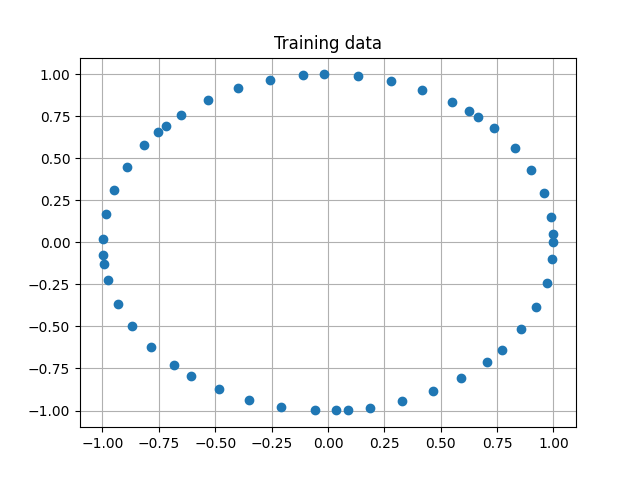

In [68]:
i_fig = 1

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
fig, ax = plt.subplots(num=i_fig)
ax.cla()
ax.plot(xs[:, 0], xs[:, 1], 'o')
ax.grid()
ax.set_title("Training data");

## Kernel matrix and eigenvectors

We define a Gaussian kernel and compute eigenvectors associated with the $\alpha = 1$ diffusion maps normalization. These eigenvectors should approximate eigenfunctions of the Laplacian on the circle. Numerically, we compute the eigendecomposition of a symmetric kernel matrix `s_mat` which is similar to the $\alpha = 1$ diffusion maps kernel matrix. We then obtain the diffusion maps eigenvectors by applying the similarity transformation to the eigenvectors of the symmetric kernel matrix. The eigenvalues and eigenvectors are returned in an arrays `lamb` and `phi`, respectively. `w` is an array that stores the inner product weights with respect to which the eigenvectors are orthonormal. Array `eta` contains approxmations of the Laplacian eigenvalues obtained from `lamb`. 

In [69]:
epsilon = 0.15 # kernel bandwidth parameter
alpha = 1 # diffusion maps normalizatino parameter
n_eig = 11 # number of eigenvectors to compute

shape_func = partial(rkhs.gaussian, epsilon)
k = fun.compose2(shape_func, rkhs.dist2)
unit = np.ones(n)
mu = riesz_dual(vec.innerp, unit)
incl = partial(fun.evaluate_at, xs)
s = rkhs.dmsym_normalize(vec, alpha, unit, incl, mu, k)
s_mat = s(xs, xs)
lamb, phi, w = rkhs.dm_eigen(s_mat, n_eig, solver='eig')
eta = lamb - 1
eta = eta / eta[1] 

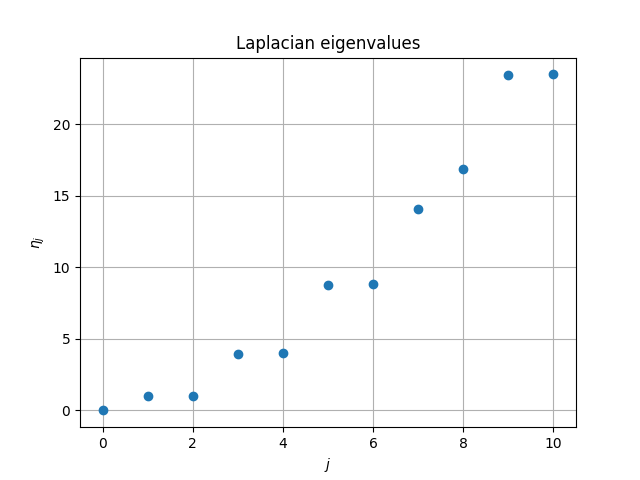

In [70]:
i_fig = 2
if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax.cla()
ax.plot(np.arange(0, n_eig), eta, 'o')
ax.grid()
ax.set_xlabel('$j$')
ax.set_ylabel('$\\eta_j$')
ax.set_title('Laplacian eigenvalues');

interactive(children=(IntSlider(value=0, continuous_update=False, description='j', max=10), Output()), _dom_cl…

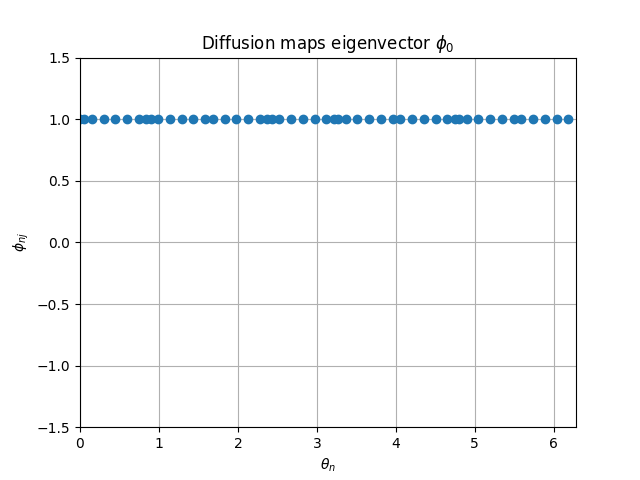

In [71]:
i_fig = 3

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
fig, ax = plt.subplots(num=i_fig)
j_slider = IntSlider(value=0, min=0, max=n_eig - 1, continuous_update=False)

@interact(j=j_slider)
def plot_phi(j):
    ax.cla()
    ax.plot(thetas, phi[:, j], 'o')
    ax.grid()
    ax.set_xlabel('$\\theta_n$')
    ax.set_ylabel('$\\phi_{nj}$')
    ax.set_title(f'Diffusion maps eigenvector $\\phi_{{{j}}}$') 
    ax.set_xlim(0, 2 * np.pi)
    ax.set_ylim(-1.5, 1.5)

## Nystrom extension

We perfom Nystrom extension to compute functions that interpolate the kernel eigenvectors. For that, we build the integral operator `p_op` associated with the diffusion maps kernel function `p` without symmetrization. We return the interpolated eigenfunctions as a list of functions `varphi`. We plot these functions on a uniform grid on the circle.

In [72]:
p = rkhs.dm_normalize(vec, alpha, unit, incl, mu, k)
incl = partial(fun.evaluate_at, xs)
p_op = rkhs.kernel_operator(vep, incl, mu, p)
nyst = rkhs.nystrom_basis(vec, p_op, lamb, phi.T)
synth = synthesis_operator(fun, nyst)
u = partial(vec.std_basis, n_eig, shape2d = 'col')
varphi = [synth(u(j)) for j in range(0, n_eig)]

In [73]:
n_grd = 400

theta_grd = np.linspace(0, 2 * np.pi, n_grd)
x_grd = dyn.circle_embedding_r2(theta_grd)

interactive(children=(IntSlider(value=0, continuous_update=False, description='j', max=10), Output()), _dom_cl…

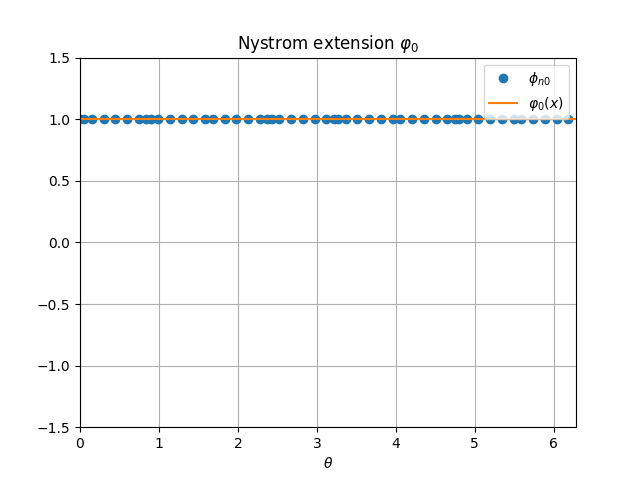

In [74]:
i_fig = 4

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
fig, ax = plt.subplots(num=i_fig)
j_slider = IntSlider(value=0, min=0, max=n_eig - 1, continuous_update=False)

@interact(j=j_slider)
def plot_varphi(j):
    ax.cla()
    ax.plot(thetas, phi[:, j], 'o', label=f'$\\phi_{{n{j}}}$')
    ax.plot(theta_grd, varphi[j](x_grd), '-', label=f'$\\varphi_{{{j}}}(x)$') 
    ax.grid()
    ax.legend()
    ax.set_xlabel('$\\theta$')
    ax.set_title(f'Nystrom extension $\\varphi_{{{j}}}$') 
    ax.set_xlim(0, 2 * np.pi)
    ax.set_ylim(-1.5, 1.5)

## Regression in the diffusion maps basis

We perform supervised learning (regression) of the standard embedding map $f: S^1 \to \mathbb R^2$ of the circle into the plane, $f(\theta) = (\cos(\theta),\sin(\theta))$. Given the falues $f(\theta_n)$ of $f$ on the training data (stored in array `xs`) we compute expansion coefficients `c` with respect to the Nystrom basis that reconstruct $f$ as a function `f_rec`. We test the accuracy of `f_rec` on a regular grid of points on the circle. 

In [75]:
w_inner = make_l2_innerp(vep, riesz_dual(vec.innerp, w))
c = w_inner(phi.T, xs.T)
f_rec = synth(c)
x_pred = f_rec(x_grd)

interactive(children=(IntSlider(value=0, continuous_update=False, description='j', max=1), Output()), _dom_cla…

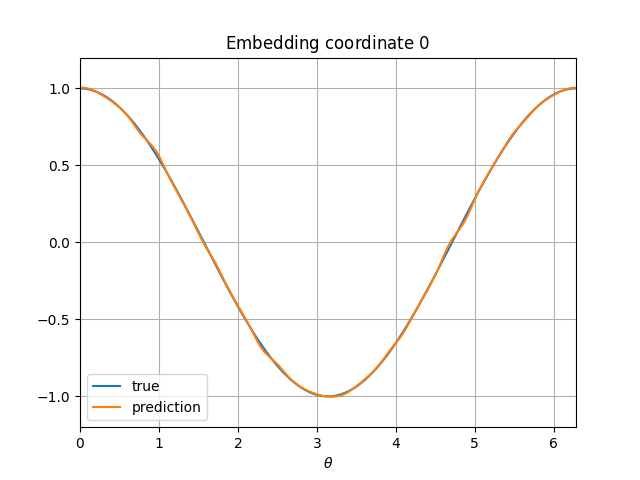

In [76]:
i_fig = 5

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
fig, ax = plt.subplots(num=i_fig)
j_slider = IntSlider(value=0, min=0, max=1, continuous_update=False)

@interact(j=j_slider)
def plot_pred(j):
    ax.cla()
    ax.plot(theta_grd, x_grd[:, j], '-', label='true')
    ax.plot(theta_grd, x_pred[:, j], '-', label='prediction') 
    ax.grid()
    ax.legend()
    ax.set_xlabel('$\\theta$')
    ax.set_title(f'Embedding coordinate ${j}$') 
    ax.set_xlim(0, 2 * np.pi)
    ax.set_ylim(-1.2, 1.2)